In [35]:
import transcriptic 
from transcriptic import commands, Container
from transcriptic.config import Connection
from transcriptic.jupyter import objects
import json
from pysd2cat.data import tx_fcs
from pysd2cat.data import pipeline
from pysd2cat.analysis import biofab_live_dead_analysis as blda

from os.path import expanduser
import requests
import os
import zipfile
import shutil
import fnmatch
import glob
import pandas as pd
import ast

from importlib import reload  # Not needed in Python 2
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt                   # For graphics
import numpy as np
%matplotlib inline



#run_id='r1dd37mcxv5pf4'
run_id='r1dk8xp9dymm54' # Time series
#run_id='r1dmsrursbqwuz'
work_dir='data/transcriptic/'+run_id
Connection.from_file("~/.transcriptic")
tx_config = json.load(open(os.path.join(expanduser("~"), ".transcriptic")))
transcriptic_email = tx_config['email']
transcriptic_token = tx_config['token']



if not os.path.exists(work_dir):
    os.makedirs(work_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def get_flow_plate_properties(run_id, transcriptic_email, transcriptic_token, work_dir, download_data=False, container="Flow (Sytox) Plate 1"):
    print("Getting data for container: " + str(container))
    fcs_path = os.path.join(work_dir, container.replace(" ", "_"))
    if not os.path.exists(fcs_path):
        os.makedirs(fcs_path)
    file_info = tx_fcs.create_fcs_manifest_and_get_files(run_id, 
                                                         transcriptic_email, 
                                                         transcriptic_token,
                                                         fcs_path=fcs_path, 
                                                         download_zip=download_data,
                                                         container_name=container
                                                         )
    print(file_info)
    #Flow plate didn't have the properties, so need to get them from another plate
    inoc_plate_info = tx_fcs.get_plate_well_properties(tx_fcs.get_tx_run(run_id), 
                                                       container_name="Inoculation Plate")
    file_info['container'] = container

    for well_id, info in file_info['aliquots'].items():
        info['properties'] = inoc_plate_info[well_id.upper()]
    return file_info

def make_row(well, info, timeseries_map=False):
    row = { 
        "well" : well,
#        "filename" : info['file'],
#        "checksum" : info['checksum']
        }
    if 'file' in info:
        row['filename'] = info['file']
    if 'checksum' in info:
        row['checksum'] = info['checksum']
    # Properties don't include sytox, so add manually
    def well_stain(well):
        if 'a' in well or 'b' in well or 'c' in well or 'd' in well:
            return "SYTOX Red Stain"
        else:
            return None
        
    row['stain'] = well_stain(well) 
    
    def expand_options(v):
        #print(v)
        kv_pairs = {}
        for option, value in v.items():
            if option == 'Reagents':
                #print(option)
                for reagent, properties in value.items():
                    if reagent == 'Ethanol':
                        kv_pairs['kill'] = reagent
                        kv_pairs['kill_volume'] = properties['final_concentration']['qty']
        return kv_pairs
    
    if timeseries_map:
        row['kill'] = 'Ethanol'
        killed = '9' not in well
        row['kill_volume'] = 300.0 if killed else 0.0 
    else:
        if 'properties' in info:
            for k, v in info['properties'].items():
                if k == 'Options':
                    row.update(expand_options(ast.literal_eval(v)))
                else:
                    row[k] = str(v)
                
                
                
    return row

def make_meta_dataframe(run_id, plate_properties, timeseries_map=False):
    data_df = pd.DataFrame()
    for well, info in plate_properties['aliquots'].items():
        row = make_row(well, info, timeseries_map=timeseries_map)
        data_df = data_df.append(row, ignore_index=True)
        
    data_df['experiment_id'] = run_id
    return data_df
        
def get_container_work_dir(out_dir, container):
    return os.path.join(out_dir, container.replace(" ", "_"))

def get_container_data(out_dir, container):
    path = os.path.join(get_container_work_dir(out_dir, container), 'data.csv')
    df = pd.read_csv(path)
    return df

def make_container_dataframes(run_id, plate_properties_list, out_dir, timeseries_map=False, overwrite=False):
    for plate_properties in plate_properties_list:
        df_path = get_container_work_dir(out_dir, plate_properties['container'])
        if not os.path.exists(df_path):
            os.makedirs(df_path)
        df_file = os.path.join(df_path, 'data.csv')
        if overwrite or not os.path.exists(df_file):
            meta_df = make_meta_dataframe(run_id, plate_properties, timeseries_map=timeseries_map)
            df = pipeline.get_data_and_metadata_df(meta_df, '.', fraction=None, max_records=30000)
            # drop bead controls in column 12
            df = df.loc[~df['well'].str.contains('12')]
            df.to_csv(df_file)
            
def extract_time_point(x):
    return x.Name.split(' ')[3].split('_')[0]
def extract_time(x):
    return x.Name.split(' ')[3].split('_')[1]
def assign_container(prefix, x, containers):
    name = prefix + ' ' + x.time_point
    #print(containers)
    return next(c for c in containers.Containers if name in c.attributes['label'])




In [36]:
run_obj = tx_fcs.get_tx_run(run_id)
d = run_obj.data

try:
    containers = run_obj.containers
except Exception as e:
    containers = run_obj.containers

flow_data = d.loc[d.Operation == 'flow_analyze']

print(flow_data)

if len(flow_data) > 0:
    flow_data.loc[:,'time_point'] = flow_data.apply(extract_time_point, axis=1)
    flow_data.loc[:,'time'] = flow_data.apply(extract_time, axis=1)
    flow_data.loc[:, 'container'] = flow_data.apply(lambda x: assign_container('Flow (Sytox) Plate', x, containers), axis=1)
    flow_data.loc[:, 'container_name'] = flow_data.apply(lambda x: x['container'].attributes['label'], axis=1)



flow_data

Attempting to fetch 16 datasets...


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/transcriptic/jupyter/objects.py:433: UserWarning: Missing key 'container' when initializing dataset
  warnings.warn("Missing key {} when initializing dataset".format(e))
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/transcriptic/jupyter/objects.py:882: UserWarning: ContainerType given is not supported yet in AP-Py
  warnings.warn("ContainerType given is not supported yet in AP-Py")


                               Name DataType     Operation AnalysisTool                                                      Datasets
4   Flow (Sytox) Plate 1_0.5 hour    file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x123410b00>
5   Flow (Sytox) Plate 2_2.0 hour    file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1234101d0>
6   Flow (Sytox) Plate 10_50.0 hour  file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x12384f240>
7   Flow (Sytox) Plate 11_60.5 hour  file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x12384f0f0>
8   Flow (Sytox) Plate 12_72.0 hour  file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x12112dd30>
9   Flow (Sytox) Plate 3_4.5 hour    file     flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x12112d748>
10  Flow (Sytox) Plate 4_8.0 hour    file     flow_analyze  No

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Name,DataType,Operation,AnalysisTool,Datasets,time_point,time,container,container_name
4,Flow (Sytox) Plate 1_0.5 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x123410b00>,1,0.5,Container(Flow (Sytox) Plate 1),Flow (Sytox) Plate 1
5,Flow (Sytox) Plate 2_2.0 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x1234101d0>,2,2.0,Container(Flow (Sytox) Plate 2),Flow (Sytox) Plate 2
6,Flow (Sytox) Plate 10_50.0 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x12384f240>,10,50.0,Container(Flow (Sytox) Plate 10),Flow (Sytox) Plate 10
7,Flow (Sytox) Plate 11_60.5 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x12384f0f0>,11,60.5,Container(Flow (Sytox) Plate 11),Flow (Sytox) Plate 11
8,Flow (Sytox) Plate 12_72.0 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x12112dd30>,12,72.0,Container(Flow (Sytox) Plate 12),Flow (Sytox) Plate 12
9,Flow (Sytox) Plate 3_4.5 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x12112d748>,3,4.5,Container(Flow (Sytox) Plate 3),Flow (Sytox) Plate 3
10,Flow (Sytox) Plate 4_8.0 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x12115ab00>,4,8.0,Container(Flow (Sytox) Plate 4),Flow (Sytox) Plate 4
11,Flow (Sytox) Plate 5_12.5 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x1216821d0>,5,12.5,Container(Flow (Sytox) Plate 5),Flow (Sytox) Plate 5
12,Flow (Sytox) Plate 6_18.0 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x121682198>,6,18.0,Container(Flow (Sytox) Plate 6),Flow (Sytox) Plate 6
13,Flow (Sytox) Plate 7_24.5 hour,file,flow_analyze,None,<transcriptic.jupyter.objects.Dataset object at 0x122c0cc50>,7,24.5,Container(Flow (Sytox) Plate 7),Flow (Sytox) Plate 7


In [37]:
plate_properties = [get_flow_plate_properties(run_id, transcriptic_email, transcriptic_token, work_dir, download_data=False, container=flow_data.container[i].attributes['label']) for i in flow_data.index]
make_container_dataframes(run_id, plate_properties, work_dir, timeseries_map=False, overwrite=False)

Getting data for container: Flow (Sytox) Plate 1
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x1240831d0>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x1234fb748>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x1241fc978>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x1241fca58>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x121a02da0>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcript

Getting data for container: Flow (Sytox) Plate 2
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x122bf7e48>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x12402ba90>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x123f70f60>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x1216b08d0>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1263e2940>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcript

Getting data for container: Flow (Sytox) Plate 10
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x123fa75f8>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x123dd35c0>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x1218e0278>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x12402b278>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x123ed1128>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcrip

Getting data for container: Flow (Sytox) Plate 11
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x121812ba8>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x124118240>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x123f79e48>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x1241fca58>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1238a0c88>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcrip

Getting data for container: Flow (Sytox) Plate 12
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x12603b898>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x123fb71d0>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x1261e9630>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x1227a4da0>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1237e7710>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcrip

Getting data for container: Flow (Sytox) Plate 3
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x12622c898>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x1211e8390>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x123e51d68>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x12186e048>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1261b36d8>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcript

Getting data for container: Flow (Sytox) Plate 4
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x1263b4550>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x1263b4b00>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x126418c88>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x1262506d8>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1262507b8>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcript

Getting data for container: Flow (Sytox) Plate 5
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x126055128>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x120ca3278>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x121260b70>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x121729ef0>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x120e9b198>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcript

Getting data for container: Flow (Sytox) Plate 6
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x123edf470>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x123fd3e48>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x123fd3390>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x123edf198>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x12383d5f8>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcript

Getting data for container: Flow (Sytox) Plate 7
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x1212076d8>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x12644b3c8>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x123e70ac8>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x122d615c0>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x1237e2518>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcript

Getting data for container: Flow (Sytox) Plate 8
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x120c8dc18>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x120c8d550>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x12610fe80>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x123f05940>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x122e84400>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcript

Getting data for container: Flow (Sytox) Plate 9
Attempting to fetch 16 datasets...
                               Name     DataType     Operation AnalysisTool                                                      Datasets
0   FLUOR-post-inoculation-read      platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x126215cf8>
1   OD-post-inoculation-read         platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x120c8d748>
2   OD-0.0 hour                      platereader  absorbance    None         <transcriptic.jupyter.objects.Dataset object at 0x1241011d0>
3   FLUOR-0.0 hour                   platereader  fluorescence  None         <transcriptic.jupyter.objects.Dataset object at 0x12633de48>
4   Flow (Sytox) Plate 1_0.5 hour    file         flow_analyze  None         <transcriptic.jupyter.objects.Dataset object at 0x12175e9e8>
5   Flow (Sytox) Plate 2_2.0 hour    file         flow_analyze  None         <transcript

In [34]:
plate_properties[1]['aliquots']['g9']

{'file': 'data/transcriptic/r1dmsrursbqwuz/Flow_(Sytox)_Plate_1/fcs/CellDeath-EtOH-10-03-2019-T12_Sytox-YeastGates_SytoxYG-Plate_G9.fcs',
 'properties': {'Control': '{}',
  'Storage (C)': 'cold_80',
  'Container Type': '96-pcr',
  'Media': "{'YPAD': {'item_id': 378596, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 1000.0, 'units': 'µl'}}}",
  'Strain': "{'S288c_a': {'item_id': 389331, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 0, 'units': 'µl'}}}",
  'Replicate': '7/8',
  'Culture_Volume': "{'qty': 1000.0, 'units': 'uL'}",
  'plate_id': '394511',
  'Options': "{'Reagents': {'Ethanol': {'final_concentration': {'qty': 0, 'units': 'ul'}, 'duration': {'qty': 60, 'units': 'minute'}}}}",
  'source': "[{'id': 393985}]"},
 'checksum': 'fa5a18056bb513c13685da5dabd2cbee1c794b64'}

In [ ]:
make_container_dataframes(run_id, plate_properties, work_dir, timeseries_map=False, overwrite=False)

In [33]:
df = get_container_data(work_dir, plate_properties[0]['container'])
df

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Container Type,Control,Culture_Volume,Media,Replicate,Storage (C),Strain,checksum,filename,kill,kill_volume,plate_id,source,stain,well,experiment_id,Time,FSC-A,SSC-A,BL1-A,RL1-A,FSC-H,SSC-H,BL1-H,RL1-H,FSC-W,SSC-W,BL1-W,RL1-W,index,live
0,0,0,0,96-pcr,{},"{'qty': 1000.0, 'units': 'uL'}","{'YPAD': {'item_id': 378596, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 1000.0, 'units': 'µl'}}}",3/8,cold_80,"{'S288c_a': {'item_id': 389331, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 0, 'units': 'µl'}}}",afe43f51e8ab4acf2274d2a339c877c50942ddd0,data/transcriptic/r1dd37mcxv5pf4/Flow_(Sytox)_Plate_1/fcs/CellDeath-EtOH-07-25-2019-Run1_Sytox-YeastGates_SytoxYG-Plate_C8.fcs,Ethanol,29.0,394511.0,[{'id': 393948}],SYTOX Red Stain,c8,r1dd37mcxv5pf4,2.0,1048575.0,1048575.0,4086.0,61290.0,91887.0,432707.0,408.0,17874.0,1023.0,1023.0,0.0,20.0,0,0
1,1,1,1,96-pcr,{},"{'qty': 1000.0, 'units': 'uL'}","{'YPAD': {'item_id': 378596, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 1000.0, 'units': 'µl'}}}",3/8,cold_80,"{'S288c_a': {'item_id': 389331, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 0, 'units': 'µl'}}}",afe43f51e8ab4acf2274d2a339c877c50942ddd0,data/transcriptic/r1dd37mcxv5pf4/Flow_(Sytox)_Plate_1/fcs/CellDeath-EtOH-07-25-2019-Run1_Sytox-YeastGates_SytoxYG-Plate_C8.fcs,Ethanol,29.0,394511.0,[{'id': 393948}],SYTOX Red Stain,c8,r1dd37mcxv5pf4,4.0,53520.0,127679.0,53.0,16235.0,52901.0,121114.0,80.0,14399.0,37.0,47.0,0.0,18.0,1,0
2,2,2,2,96-pcr,{},"{'qty': 1000.0, 'units': 'uL'}","{'YPAD': {'item_id': 378596, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 1000.0, 'units': 'µl'}}}",3/8,cold_80,"{'S288c_a': {'item_id': 389331, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 0, 'units': 'µl'}}}",afe43f51e8ab4acf2274d2a339c877c50942ddd0,data/transcriptic/r1dd37mcxv5pf4/Flow_(Sytox)_Plate_1/fcs/CellDeath-EtOH-07-25-2019-Run1_Sytox-YeastGates_SytoxYG-Plate_C8.fcs,Ethanol,29.0,394511.0,[{'id': 393948}],SYTOX Red Stain,c8,r1dd37mcxv5pf4,9.0,53273.0,112986.0,-112.0,58.0,53268.0,107062.0,54.0,84.0,37.0,47.0,0.0,0.0,2,1
3,3,3,3,96-pcr,{},"{'qty': 1000.0, 'units': 'uL'}","{'YPAD': {'item_id': 378596, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 1000.0, 'units': 'µl'}}}",3/8,cold_80,"{'S288c_a': {'item_id': 389331, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 0, 'units': 'µl'}}}",afe43f51e8ab4acf2274d2a339c877c50942ddd0,data/transcriptic/r1dd37mcxv5pf4/Flow_(Sytox)_Plate_1/fcs/CellDeath-EtOH-07-25-2019-Run1_Sytox-YeastGates_SytoxYG-Plate_C8.fcs,Ethanol,29.0,394511.0,[{'id': 393948}],SYTOX Red Stain,c8,r1dd37mcxv5pf4,10.0,90642.0,279586.0,82.0,183.0,73484.0,230423.0,77.0,128.0,48.0,82.0,0.0,0.0,3,1
4,4,4,4,96-pcr,{},"{'qty': 1000.0, 'units': 'uL'}","{'YPAD': {'item_id': 378596, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 1000.0, 'units': 'µl'}}}",3/8,cold_80,"{'S288c_a': {'item_id': 389331, 'item_concentration': None, 'final_concentration': None, 'dilution_factor': None, 'working_volume': {'qty': 0, 'units': 'µl'}}}",afe43f51e8ab4acf2274d2a339c877c50942ddd0,data/transcriptic/r1dd37mcxv5pf4/Flow_(Sytox)_Plate_1/fcs/CellDeath-EtOH-07-25-2019-Run1_Sytox-YeastGates_SytoxYG-Plate_C8.fcs,Ethanol,29.0,394511.0,[{'id': 393948}],SYTOX Red Stain,c8,r1dd37mcxv5pf4,12.0,45356.0,152291.0,-22.0,100.0,48443.0,163411.0,69.0,114.0,33.0,48.0,0.0,0.0,4,1
5,5,5,5,96-pcr,{},"{'qty': 1000.0, 'units': 'uL'}","{'YPAD': {'item_id': 378596, 'item_concentration': None, 'final_concentration': None, 'd

In [27]:
for p in plate_properties:
    df = get_container_data(work_dir, p['container'])
    time_point = flow_data.loc[flow_data['container_name'] == p['container']]['time_point'].iloc[0]
    dead_volumes = list(df.kill_volume.dropna().unique())
    dead_volumes.remove(0.0)
    blda.train_models_for_stats(df, 
                            data_dir=work_dir, 
                            dead_volumes=dead_volumes,
                            fcs_columns=['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 
                                      'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W',
                                      'BL1-W', 'RL1-W'],
                           time_point=time_point)



/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 0, 'live_volume': 0.0, 'dead_volume': 29.0, 'stain': 'SYTOX Red Stain', 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 0, 'live_volume': 0.0, 'dead_volume': 29.0, 'stain': nan, 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 0, 'live_volume': 0.0, 'dead_volume': 980.0, 'stain': 'SYTOX Red Stain', 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 0, 'live_volume': 0.0, 'dead_volume': 980.0, 'stain': nan, 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 0, 'live_volume': 0.0, 'dead_volume': 370.0, 'stain': 'SYTOX Red Stain', 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 0, 'live_volume': 0.0, 'dead_volume': 370.0, 'stain': nan, 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 0, 'live_volume': 0.0, 'dead_volume': 570.0, 'stain': 'SYTOX Red Stain', 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 

{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 3, 'live_volume': 0.0, 'dead_volume': 170.0, 'stain': 'SYTOX Red Stain', 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 3, 'live_volume': 0.0, 'dead_volume': 170.0, 'stain': nan, 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 3, 'live_volume': 0.0, 'dead_volume': 250.0, 'stain': 'SYTOX Red Stain', 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 3, 'live_volume': 0.0, 'dead_volume': 250.0, 'stain': nan, 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 4, 'live_volume': 0.0, 'dead_volume': 29.0, 'stain': 'SYTOX Red Stain', 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 4, 'live_volume': 0.0, 'dead_volume': 29.0, 'stain': nan, 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 'random_state': 4, 'live_volume': 0.0, 'dead_volume': 980.0, 'stain': 'SYTOX Red Stain', 'time_point': '1'}
{'experiment_id': 'r1dd37mcxv5pf4', 

In [46]:
## Use last time point to predict live/dead for earlier time points

last_time = flow_data.loc[flow_data['time_point'].astype(int).idxmax()]
last_plate = [p for p in plate_properties if p['container'] == last_time['container_name']][0]
classifier_df = get_container_data(work_dir, last_plate['container'])
for p in plate_properties:
    df = get_container_data(work_dir, p['container'])
    time_point = flow_data.loc[flow_data['container_name'] == p['container']]['time_point'].iloc[0]
    dead_volumes = list(df.kill_volume.dropna().unique())
    dead_volumes.remove(0.0)

    pred_df = blda.train_models_for_prediction(classifier_df,
                                               df, 
                                               data_dir=work_dir,
                                 fcs_columns=['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 
                                      'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W',
                                      'BL1-W', 'RL1-W'],
                                               dead_strain_name=max(dead_volumes),
                                           combine_stains=False,
                                          overwrite=True,
                                          output_col = 'live',
                                              time_point=time_point)
    out_file = os.path.join(get_container_work_dir(work_dir, p['container']), 'data.csv')
    pred_df.to_csv(out_file)



output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '1'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']
['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:00:39
Normalizing training and testing splits...
Starting Classification training...
Training time was: 187.53 seconds
Testing time was: 5.50 seconds
Prediction time of untested data was: 24.523411989212036

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:04:46
Normalizing training and testing splits...
Starting Classification training...
Training time was: 174.69 seconds
Testing time was: 5.82 seconds
Prediction time of untested data was: 27.665440797805786

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                           Data and Split Description Normalized Num Features Normalized Feature Extraction W

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '2'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:09:19
Normalizing training and testing splits...
Starting Classification training...
Training time was: 174.69 seconds
Testing time was: 4.86 seconds
Prediction time of untested data was: 1230.7909829616547

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                         Data and Split Description Normalized Num Features Normalized Featur

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:33:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 309.99 seconds
Testing time was: 5.18 seconds
Prediction time of untested data was: 24.597946882247925

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                           Data and Split Description Normalized Num Features Normalized Feature Extraction W

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '10'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:40:02
Normalizing training and testing splits...
Starting Classification training...
Training time was: 125.57 seconds
Testing time was: 2.56 seconds
Prediction time of untested data was: 11.902289867401123

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                          Data and Split Description Normalized Num Features Normalized Featu

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:42:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 128.05 seconds
Testing time was: 4.57 seconds
Prediction time of untested data was: 19.545439958572388

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                            Data and Split Description Normalized Num Features Normalized Feature Extraction 

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '11'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:46:30
Normalizing training and testing splits...
Starting Classification training...
Training time was: 125.10 seconds
Testing time was: 2.64 seconds
Prediction time of untested data was: 12.032186031341553

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                          Data and Split Description Normalized Num Features Normalized Featu

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:49:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 130.07 seconds
Testing time was: 3.25 seconds
Prediction time of untested data was: 22.994540214538574

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                            Data and Split Description Normalized Num Features Normalized Feature Extraction 

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '12'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:52:56
Normalizing training and testing splits...
Starting Classification training...
Training time was: 135.03 seconds
Testing time was: 3.05 seconds
Prediction time of untested data was: 14.578696966171265

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                          Data and Split Description Normalized Num Features Normalized Featu

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:55:58
Normalizing training and testing splits...
Starting Classification training...
Training time was: 128.85 seconds
Testing time was: 3.66 seconds
Prediction time of untested data was: 16.813427925109863

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                            Data and Split Description Normalized Num Features Normalized Feature Extraction 

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '3'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 13:59:30
Normalizing training and testing splits...
Starting Classification training...
Training time was: 170.22 seconds
Testing time was: 5.59 seconds
Prediction time of untested data was: 26.071317195892334

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                         Data and Split Description Normalized Num Features Normalized Featur

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:03:21
Normalizing training and testing splits...
Starting Classification training...
Training time was: 199.56 seconds
Testing time was: 7.31 seconds
Prediction time of untested data was: 34.55344486236572

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                           Data and Split Description Normalized Num Features Normalized Feature Extraction Wa

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '4'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:08:30
Normalizing training and testing splits...
Starting Classification training...
Training time was: 204.00 seconds
Testing time was: 6.11 seconds
Prediction time of untested data was: 27.68628478050232

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                         Data and Split Description Normalized Num Features Normalized Feature

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:13:02
Normalizing training and testing splits...
Starting Classification training...
Training time was: 201.13 seconds
Testing time was: 6.10 seconds
Prediction time of untested data was: 32.57302188873291

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                           Data and Split Description Normalized Num Features Normalized Feature Extraction Wa

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '5'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:18:06
Normalizing training and testing splits...
Starting Classification training...
Training time was: 176.11 seconds
Testing time was: 4.18 seconds
Prediction time of untested data was: 21.957508087158203

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                         Data and Split Description Normalized Num Features Normalized Featur

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:21:59
Normalizing training and testing splits...
Starting Classification training...
Training time was: 224.85 seconds
Testing time was: 7.13 seconds
Prediction time of untested data was: 36.217609882354736

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                           Data and Split Description Normalized Num Features Normalized Feature Extraction W

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '6'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:27:46
Normalizing training and testing splits...
Starting Classification training...
Training time was: 201.78 seconds
Testing time was: 5.50 seconds
Prediction time of untested data was: 25.154775142669678

         Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                         Data and Split Description Normalized Num Features Normalized Feature

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:32:13
Normalizing training and testing splits...
Starting Classification training...
Training time was: 240.35 seconds
Testing time was: 7.84 seconds
Prediction time of untested data was: 35.240066051483154

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                           Data and Split Description Normalized Num Features Normalized Feature Extraction W

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
SYTOX Red Stain
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': 'SYTOX Red Stain', 'prediction': True, 'time_point': '7'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:38:27
Normalizing training and testing splits...
Starting Classification training...
Training time was: 195.27 seconds
Testing time was: 5.08 seconds
Prediction time of untested data was: 22.43387198448181

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                         Data and Split Description Normalized Num Features Normalized Feature

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:42:48
Normalizing training and testing splits...
Starting Classification training...
Training time was: 229.21 seconds
Testing time was: 6.55 seconds
Prediction time of untested data was: 30.663684844970703

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                           Data and Split Description Normalized Num Features Normalized Feature Extraction W

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
nan
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': nan, 'prediction': True, 'time_point': '8'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:48:30
Normalizing training and testing splits...
Starting Classification training...
Training time was: 146.32 seconds
Testing time was: 3.77 seconds
Prediction time of untested data was: 18.854570865631104

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                           Data and Split Description Normalized Num Features Normalized Feature Extraction W

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:51:49
Normalizing training and testing splits...
Starting Classification training...
Training time was: 146.57 seconds
Testing time was: 3.30 seconds
Prediction time of untested data was: 15.473590850830078

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                         Data and Split Description Normalized Num Features Normalized Featur

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


output_col: live
nan
{'experiment_id': 'r1dk8xp9dymm54', 'random_state': 0, 'live_volume': 0, 'dead_volume': 300.0, 'stain': nan, 'prediction': True, 'time_point': '9'}
data_columns: ['Unnamed: 0', 'Unnamed: 0.1', 'checksum', 'filename', 'kill', 'kill_volume', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:55:40
Normalizing training and testing splits...
Starting Classification training...
Training time was: 146.45 seconds
Testing time was: 3.71 seconds
Prediction time of untested data was: 18.012270212173462

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                           Data and Split Description Normalized Num Features Normalized Feature Extraction W

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W']

----------------------------------------------------------------------------------------------------
Starting run at time 14:58:58
Normalizing training and testing splits...
Starting Classification training...
Training time was: 137.77 seconds
Testing time was: 3.07 seconds
Prediction time of untested data was: 14.952860832214355

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                                                                                                                         Data and Split Description Normalized Num Features Normalized Featur

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,2,3,4,5,6,7,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, comp

Index(['Container Type', 'Control', 'Culture_Volume', 'Media', 'Replicate', 'Storage (C)', 'Strain', 'checksum', 'filename', 'kill', 'kill_volume', 'plate_id', 'source', 'stain', 'well', 'experiment_id', 'Time', 'FSC-A', 'SSC-A', 'BL1-A', 'RL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'RL1-H', 'FSC-W', 'SSC-W', 'BL1-W', 'RL1-W', 'index', 'live', 'live_ss'], dtype='object')


Text(0.5, 0, 'Ethanol %')

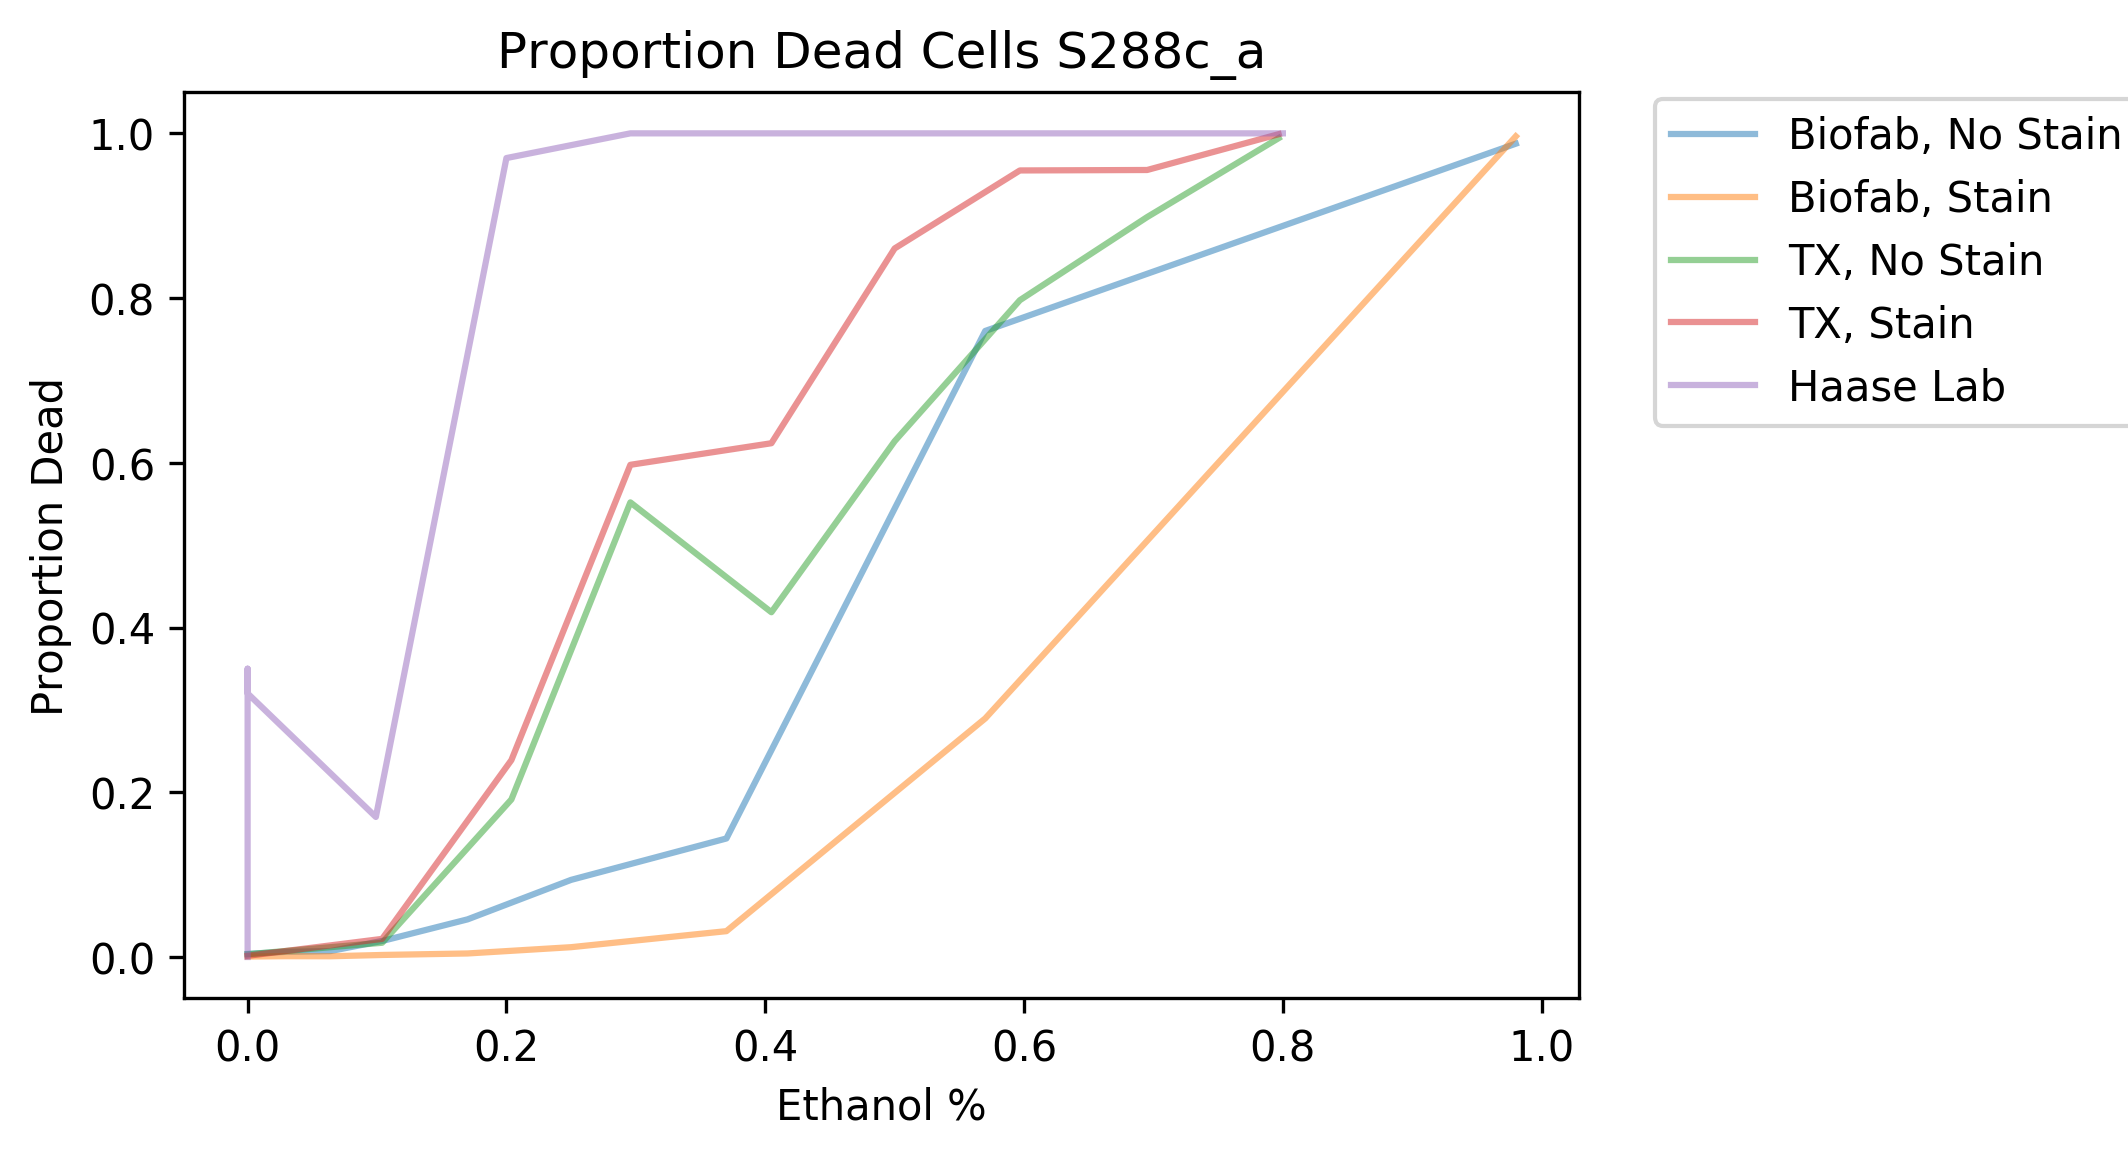

In [29]:
# For each sample, what proportion are dead?

experiments = [
    'experiment.uw_biofab.34601',
    'experiment.uw_biofab.34600',
    'r1dd37mcxv5pf4',
    'r1dk8xp9dymm54'
]

run_strain = {
    'experiment.uw_biofab.34600' : 'CEN.PK2 - MAT A',
    'experiment.uw_biofab.34601' : 'S288c_a',
    'r1dd37mcxv5pf4' : 'S288c_a',
    'r1dk8xp9dymm54' : 'S288c_a'
}

experiment_lab = {
    'experiment.uw_biofab.34600' : 'BioFab',
    'experiment.uw_biofab.34601' : 'BioFab',
    'r1dd37mcxv5pf4' : 'TX',
    'r1dk8xp9dymm54' : 'TX'
}

robs_experiment = pd.read_csv('../resources/6-12_percent_dead.csv')

data_dir = os.path.join('data/biofab', experiments[1])
all_data_file = os.path.join(data_dir, 'data.csv')
experiment_df = pd.read_csv(all_data_file, index_col=0)


data_dir1 = os.path.join('data/transcriptic')
all_data_file1 = os.path.join(data_dir1, 'data.csv')
experiment_df1 = pd.read_csv(all_data_file1, index_col=0)
print(experiment_df1.columns)

#dead_proportion = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume', 'sample_id', 'stain'])['live'].agg(lambda x: 1 - x.mean()).groupby(['kill_volume', 'stain']).agg(np.mean).reset_index().rename(columns={'live' : 'dead'})
dead_proportion = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume',  'stain'])['live'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live' : 'dead'})
dead_proportion = dead_proportion.loc[dead_proportion.kill_volume != "None"]
#dead_proportion_ss = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume', 'sample_id', 'stain'])['live_ss'].agg(lambda x: 1 - x.mean()).groupby(['kill_volume', 'stain']).agg(np.mean).reset_index().rename(columns={'live_ss' : 'dead_ss'})
dead_proportion_ss = experiment_df.where((pd.notnull(experiment_df)), "None").groupby(['kill_volume', 'stain'])['live_ss'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live_ss' : 'dead_ss'})
dead_proportion_ss = dead_proportion_ss.loc[dead_proportion_ss.kill_volume != "None"]


#dead_proportion1 = experiment_df1.where((pd.notnull(experiment_df1)), "None").groupby(['kill_volume', 'well', 'stain'])['live'].agg(lambda x: 1 - x.mean()).groupby(['kill_volume', 'stain']).agg(np.mean).reset_index().rename(columns={'live' : 'dead'})
dead_proportion1 = experiment_df1.where((pd.notnull(experiment_df1)), "None").groupby(['kill_volume', 'stain'])['live'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live' : 'dead'})
dead_proportion1 = dead_proportion1.loc[dead_proportion1.kill_volume != "None"]
dead_proportion1_ss = experiment_df1.where((pd.notnull(experiment_df1)), "None").groupby(['kill_volume', 'stain'])['live_ss'].agg(lambda x: 1 - x.mean()).reset_index().rename(columns={'live_ss' : 'dead_ss'})
dead_proportion1_ss = dead_proportion1_ss.loc[dead_proportion1_ss.kill_volume != "None"]



#experiment_id = experiment_df.experiment_id.dropna().unique()[0]
experiment_id = experiment_df.strain.dropna().unique()[0]
#print(dead_proportion)
fig = plt.figure(dpi=300)
ax = plt.subplot(111)
percentages=[ 100*x for x in [0, .03, .06, .10, .15, .20, .27, .36, .49]]

df=dead_proportion.loc[dead_proportion.stain == "None"]
ax.plot(df['kill_volume']/1000, df['dead'], label="Biofab, No Stain", alpha=0.5)
df=dead_proportion.loc[dead_proportion.stain == "SYTOX Red Stain"]
ax.plot(df['kill_volume']/1000, df['dead'], label="Biofab, Stain", alpha=0.5)
#df=dead_proportion_ss.loc[dead_proportion_ss.stain == "None"]
#ax.plot(df['kill_volume']/1000, df['dead_ss'], label="Biofab, No Stain, SS", alpha=0.5)
#df=dead_proportion_ss.loc[dead_proportion_ss.stain == "SYTOX Red Stain"]
#ax.plot(df['kill_volume']/1000, df['dead_ss'], label="Biofab, Stain, SS", alpha=0.5)


df=dead_proportion1.loc[dead_proportion1.stain == "None"]
ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead'], label="TX, No Stain", alpha=0.5)
df=dead_proportion1.loc[dead_proportion1.stain == "SYTOX Red Stain"]
ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead'], label="TX, Stain", alpha=0.5)
#df=dead_proportion1_ss.loc[dead_proportion1_ss.stain == "None"]
#ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead_ss'], label="TX, No Stain, SS", alpha=0.5)
#df=dead_proportion1_ss.loc[dead_proportion1_ss.stain == "SYTOX Red Stain"]
#ax.plot(df['kill_volume']/(df['kill_volume']+250), df['dead_ss'], label="TX, Stain, SS", alpha=0.5)


ax.plot(robs_experiment["Ethanol vol (ul)"]/(robs_experiment["Ethanol vol (ul)"]+robs_experiment["culture vol (ul)"]), 
        robs_experiment['% Dead'], label="Haase Lab", alpha=0.5)
#ax.bar()
#ax.set_xscale('log')
fig.legend(bbox_to_anchor=(1.2, 0.9))
plt.title("Proportion Dead Cells "  + experiment_id)
ax.set_ylabel("Proportion Dead")
ax.set_xlabel("Ethanol %")
#plt.xticks(range(0, len(volumes)), volumes)

